# Video segmentation with SAM 2

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !pip install supervision
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.0 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-kn78s5lq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-kn78s5lq
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.

## Set-up

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import supervision as sv
from supervision.assets import download_assets, VideoAssets
from pathlib import Path
from PIL import Image, ImageOps
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))
def apply_color_and_gray_effect(frame_path, mask):

    frame = Image.open(frame_path).convert("RGB")
    frame_array = np.array(frame)

    gray_frame = ImageOps.grayscale(frame)
    gray_frame_array = np.array(gray_frame)
    gray_frame_array = np.stack([gray_frame_array] * 3, axis=-1)

    if mask.ndim > 2:
        mask = np.squeeze(mask)
    if mask.shape != frame_array.shape[:2]:
        raise ValueError(f"Mask dimensions {mask.shape} do not match frame dimensions {frame_array.shape[:2]}")


    result_array = np.where(mask[..., None], frame_array, gray_frame_array)

    if result_array.ndim > 3:
        result_array = np.squeeze(result_array)

    result_image = Image.fromarray(result_array.astype(np.uint8))
    return result_image


Input the video and get the sliced frame of the video




In [ ]:
# please replace the dir of the video by yourself
SOURCE_VIDEO = "/content/Video1.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=1280, height=720, fps=23, total_frames=1438)

In [ ]:
# you can choose the frames you want to use according to the above information
SCALE_FACTOR = 0.5
START_IDX = 0
END_IDX = 1400

In [ ]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

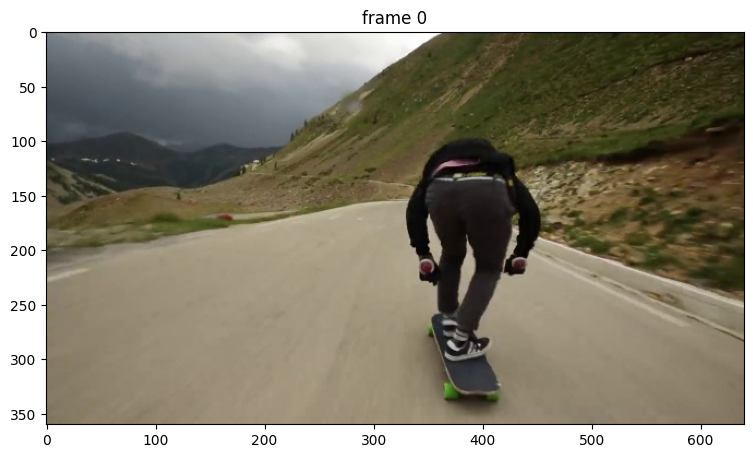

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg` for this part please choose the Dir where u genearate
video_dir = "/content/Video1"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [ ]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 1400/1400 [00:35<00:00, 39.80it/s]


Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [ ]:
predictor.reset_state(inference_state)


Here we make a **positive click** at the position of your desire with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

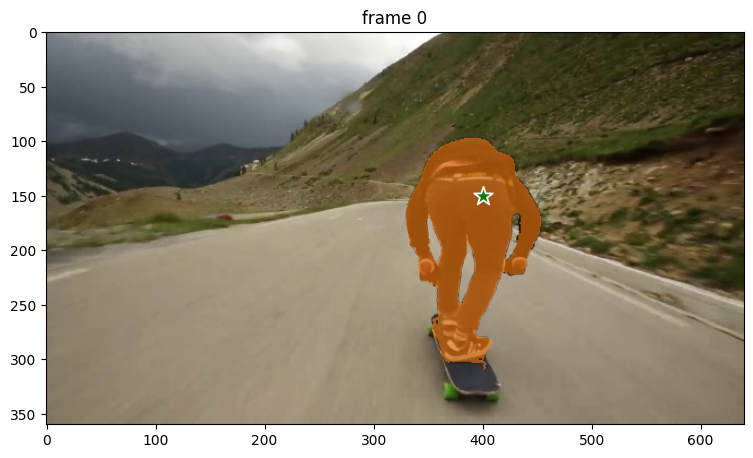

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

points = np.array([[400, 150]], dtype=np.float32)

labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:

output_video_path = "output_video.mp4"
frame_rate = 30
frame_size = None

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = None

video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


vis_frame_stride = 1

for out_frame_idx in range(0, len(frame_names), vis_frame_stride):

    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])

    combined_mask = np.any(
        [out_mask for out_mask in video_segments[out_frame_idx].values()], axis=0
    )

    result_image = apply_color_and_gray_effect(frame_path, combined_mask)

    result_frame = cv2.cvtColor(np.array(result_image), cv2.COLOR_RGB2BGR)

    if video_writer is None:
        frame_size = result_frame.shape[1], result_frame.shape[0]  # (width, height)
        video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, frame_size)

    video_writer.write(result_frame)

    print(f"Processed frame {out_frame_idx}/{len(frame_names)}")

video_writer.release()

print(f"Output video saved to {output_video_path}")


propagate in video: 100%|██████████| 1400/1400 [01:06<00:00, 20.96it/s]


Processed frame 0/1400
Processed frame 1/1400
Processed frame 2/1400
Processed frame 3/1400
Processed frame 4/1400
Processed frame 5/1400
Processed frame 6/1400
Processed frame 7/1400
Processed frame 8/1400
Processed frame 9/1400
Processed frame 10/1400
Processed frame 11/1400
Processed frame 12/1400
Processed frame 13/1400
Processed frame 14/1400
Processed frame 15/1400
Processed frame 16/1400
Processed frame 17/1400
Processed frame 18/1400
Processed frame 19/1400
Processed frame 20/1400
Processed frame 21/1400
Processed frame 22/1400
Processed frame 23/1400
Processed frame 24/1400
Processed frame 25/1400
Processed frame 26/1400
Processed frame 27/1400
Processed frame 28/1400
Processed frame 29/1400
Processed frame 30/1400
Processed frame 31/1400
Processed frame 32/1400
Processed frame 33/1400
Processed frame 34/1400
Processed frame 35/1400
Processed frame 36/1400
Processed frame 37/1400
Processed frame 38/1400
Processed frame 39/1400
Processed frame 40/1400
Processed frame 41/1400
Pr